# Imports and datasets creation

In [ ]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.datasets import make_moons, make_blobs, make_circles
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False

In [ ]:
def get_iris_np():
  columnn_names = ["f1", "f2", "f3", "f4", "label"]
  notebook_path = os.path.abspath("autoencoder_iris_clustering.ipynb")
  data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/iris.data")
  df = pd.read_csv(data_path, header=None, names=columnn_names)
  data = df[["f1", "f2", "f3", "f4"]]
  labels = df["label"]

  data = np.array(data)
  labels = np.array(labels)

  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  data = data.astype("float")

  label_encoder = LabelEncoder()
  labels = label_encoder.fit_transform(labels)
  labels = labels.astype("int")

  total_size = data.shape[0]
  random_permutation = np.random.permutation(np.arange(total_size))
  data = data[random_permutation]
  labels = labels[random_permutation]

  return data, labels

def get_iris_dataloader(batch_size=50):
	data, labels = get_iris_np()

	# Convert to tensor dataset
	data = torch.Tensor(data)
	data_shape = data.shape[1]
	labels = torch.Tensor(labels)
	final_dataset = TensorDataset(data, labels)
	dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

	return dataloader, data_shape

In [ ]:
iris_datapoints, iris_labels = get_iris_np()
iris_dataloader, iris_data_shape = get_iris_dataloader()

In [ ]:
print(iris_data_shape, len(iris_datapoints))

4 150


# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          nn.Sigmoid(),
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x = x.float()
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 50
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Iris clustering

In [ ]:
kmeans_3_clusters = KMeans(n_clusters=3, n_init=100).fit(iris_datapoints)
retrieved_labels_3_clusters = transform_clusters_to_labels(kmeans_3_clusters.labels_, iris_labels)

print("K_means greedy accuracy score for 3 clusters on initial space:",accuracy_score(iris_labels, retrieved_labels_3_clusters))
print("K_means hungarian accuracy score for 3 clusters on initial space:",cluster_accuracy(iris_labels, kmeans_3_clusters.labels_)[1])
print("K-means normalised mutual info score for 3 clusters on initial space:",normalized_mutual_info_score(iris_labels, kmeans_3_clusters.labels_))
print("K-means ARI for 3 clusters on initial space:",adjusted_rand_score(iris_labels, kmeans_3_clusters.labels_))
print("K-means silhouette score for 3 clusters on initial space:",silhouette_score(iris_datapoints, kmeans_3_clusters.labels_))

K_means greedy accuracy score for 3 clusters on initial space: 0.8866666666666667
K_means hungarian accuracy score for 3 clusters on initial space: 0.8866666666666667
K-means normalised mutual info score for 3 clusters on initial space: 0.7419116631817836
K-means ARI for 3 clusters on initial space: 0.7163421126838476
K-means silhouette score for 3 clusters on initial space: 0.5043188549150883


In [ ]:
aggloClustering_3_clusters = AgglomerativeClustering(n_clusters=3).fit(iris_datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_3_clusters.labels_, iris_labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(iris_labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(iris_labels, aggloClustering_3_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(iris_labels, aggloClustering_3_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(iris_labels, aggloClustering_3_clusters.labels_))
print("Agglomerative clustering silhouette score for 10 clusters on initial space:",silhouette_score(iris_datapoints, aggloClustering_3_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.8866666666666667
Agglomerative clustering on initial space hungarian accuracy score: 0.8866666666666667
Normalised mutual info score on agglomerative clustering on initial space: 0.7837403461384025
Agglomerative clustering ARI on initial space: 0.7195837484778036
Agglomerative clustering silhouette score for 10 clusters on initial space: 0.5043490792923951


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(iris_datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.006s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.121663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.578178
[t-SNE] KL divergence after 400 iterations: 0.220033


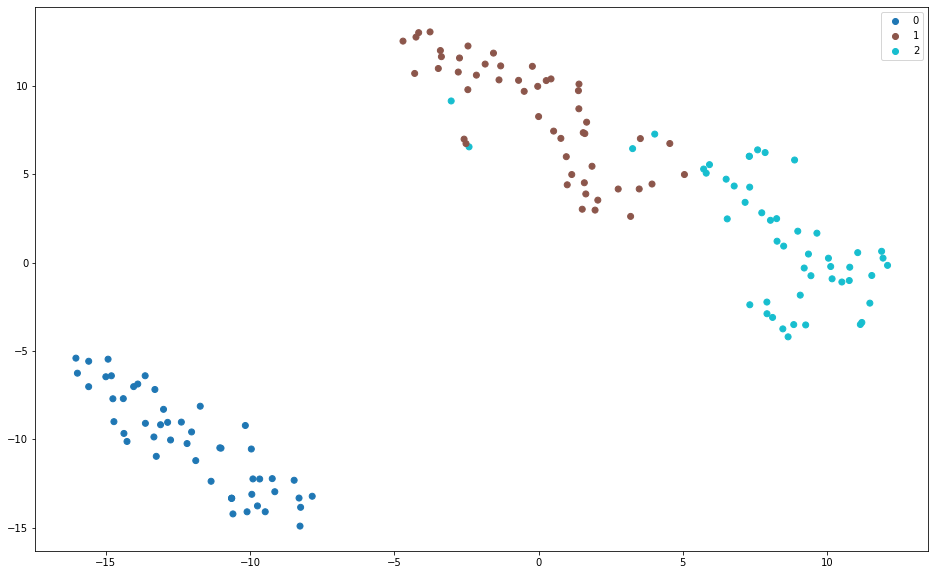

In [ ]:
dataset_labels = [0,1,2]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=iris_labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=3, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=3).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)
    agglo_silhouette = k_means_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)
    agglo_silhouette_scores.append(agglo_silhouette)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
res = run_experiment(25, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.073904
Epoch: 2/50, Loss: 0.028256
Epoch: 3/50, Loss: 0.015489
Epoch: 4/50, Loss: 0.010264
Epoch: 5/50, Loss: 0.008406
Epoch: 6/50, Loss: 0.008316
Epoch: 7/50, Loss: 0.008463
Epoch: 8/50, Loss: 0.008440
Epoch: 9/50, Loss: 0.008191
Epoch: 10/50, Loss: 0.007798
Epoch: 11/50, Loss: 0.007321
Epoch: 12/50, Loss: 0.006832
Epoch: 13/50, Loss: 0.006441
Epoch: 14/50, Loss: 0.006202
Epoch: 15/50, Loss: 0.006046
Epoch: 16/50, Loss: 0.005877
Epoch: 17/50, Loss: 0.005676
Epoch: 18/50, Loss: 0.005490
Epoch: 19/50, Loss: 0.005344
Epoch: 20/50, Loss: 0.005224
Epoch: 21

In [ ]:
print(np.mean(res[7]))
print(np.std(res[7]))

0.40608674
0.041169383


In [ ]:
results_for_k_5 = run_experiment(5, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 5 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.86
K_means hungarian accuracy score (initial space): 0.86
Normalised mutual info score (initial space): 0.7593367628576809
ARI (initial space): 0.6736713703529151 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.075548
Epoch: 2/50, Loss: 0.032737
Epoch: 3/50, Loss: 0.018117
Epoch: 4/50, Loss: 0.011586
Epoch: 5/50, Loss: 0.010130
Epoch: 6/50, Loss: 0.009883
Epoch: 7/50, Loss: 0.009390
Epoch: 8/50, Loss: 0.008945
Epoch: 9/50, Loss: 0.008590
Epoch: 10/50, Loss: 0.008163
Epoch: 11/50, Loss: 0.007734
Epoch: 12/50, Loss: 0.007383
Epoch: 13/50, Loss: 0.007111
Epoch: 14/50, Loss: 0.006880
Epoch: 15/50, Loss: 0.006651
Epoch: 16/50, Loss: 0.006403
Epoch: 17/50, Loss: 0.006167
Epoch: 18/50, Loss: 0.005987
Epoch: 19/50, Loss: 0.005836
Epoch: 20/50, Loss: 0.005674
Epoch: 21/50, Loss: 0.005505
Epoch: 22

In [ ]:
results_for_k_10 = run_experiment(10, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 10 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.92
K_means hungarian accuracy score (initial space): 0.92
Normalised mutual info score (initial space): 0.7808311536749418
ARI (initial space): 0.7861639322874197 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.064287
Epoch: 2/50, Loss: 0.025638
Epoch: 3/50, Loss: 0.012057
Epoch: 4/50, Loss: 0.009127
Epoch: 5/50, Loss: 0.009320
Epoch: 6/50, Loss: 0.009191
Epoch: 7/50, Loss: 0.008558
Epoch: 8/50, Loss: 0.008320
Epoch: 9/50, Loss: 0.007749
Epoch: 10/50, Loss: 0.007090
Epoch: 11/50, Loss: 0.006599
Epoch: 12/50, Loss: 0.006163
Epoch: 13/50, Loss: 0.005900
Epoch: 14/50, Loss: 0.005830
Epoch: 15/50, Loss: 0.005770
Epoch: 16/50, Loss: 0.005639
Epoch: 17/50, Loss: 0.005486
Epoch: 18/50, Loss: 0.005327
Epoch: 19/50, Loss: 0.005183
Epoch: 20/50, Loss: 0.005076
Epoch: 21/50, Loss: 0.004973
Epoch: 2

In [ ]:
results_for_k_15 = run_experiment(15, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9666666666666667
K_means hungarian accuracy score (initial space): 0.9666666666666667
Normalised mutual info score (initial space): 0.8801106732223012
ARI (initial space): 0.9037141640512019 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.055311
Epoch: 2/50, Loss: 0.021214
Epoch: 3/50, Loss: 0.009002
Epoch: 4/50, Loss: 0.006301
Epoch: 5/50, Loss: 0.006463
Epoch: 6/50, Loss: 0.006981
Epoch: 7/50, Loss: 0.007218
Epoch: 8/50, Loss: 0.007187
Epoch: 9/50, Loss: 0.006816
Epoch: 10/50, Loss: 0.006338
Epoch: 11/50, Loss: 0.005858
Epoch: 12/50, Loss: 0.005431
Epoch: 13/50, Loss: 0.004985
Epoch: 14/50, Loss: 0.004664
Epoch: 15/50, Loss: 0.004484
Epoch: 16/50, Loss: 0.004420
Epoch: 17/50, Loss: 0.004393
Epoch: 18/50, Loss: 0.004176
Epoch: 19/50, Loss: 0.004074
Epoch: 20/50, Loss: 0.003975
Epoch: 21

In [ ]:
results_for_k_20 = run_experiment(20, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.96
K_means hungarian accuracy score (initial space): 0.96
Normalised mutual info score (initial space): 0.8862311759668319
ARI (initial space): 0.8859501978730681 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.082048
Epoch: 2/50, Loss: 0.036294
Epoch: 3/50, Loss: 0.018530
Epoch: 4/50, Loss: 0.010740
Epoch: 5/50, Loss: 0.007815
Epoch: 6/50, Loss: 0.006872
Epoch: 7/50, Loss: 0.006788
Epoch: 8/50, Loss: 0.006879
Epoch: 9/50, Loss: 0.006875
Epoch: 10/50, Loss: 0.006650
Epoch: 11/50, Loss: 0.006238
Epoch: 12/50, Loss: 0.005888
Epoch: 13/50, Loss: 0.005709
Epoch: 14/50, Loss: 0.005577
Epoch: 15/50, Loss: 0.005438
Epoch: 16/50, Loss: 0.005318
Epoch: 17/50, Loss: 0.005214
Epoch: 18/50, Loss: 0.005113
Epoch: 19/50, Loss: 0.005015
Epoch: 20/50, Loss: 0.004927
Epoch: 21/50, Loss: 0.004832
Epoch: 2

In [ ]:
results_for_k_25 = run_experiment(25, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9533333333333334
K_means hungarian accuracy score (initial space): 0.9533333333333334
Normalised mutual info score (initial space): 0.8464828103876364
ARI (initial space): 0.8680377279943841 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.044395
Epoch: 2/50, Loss: 0.013999
Epoch: 3/50, Loss: 0.009605
Epoch: 4/50, Loss: 0.008883
Epoch: 5/50, Loss: 0.008387
Epoch: 6/50, Loss: 0.007800
Epoch: 7/50, Loss: 0.007647
Epoch: 8/50, Loss: 0.007404
Epoch: 9/50, Loss: 0.006950
Epoch: 10/50, Loss: 0.006582
Epoch: 11/50, Loss: 0.006369
Epoch: 12/50, Loss: 0.006177
Epoch: 13/50, Loss: 0.006001
Epoch: 14/50, Loss: 0.005840
Epoch: 15/50, Loss: 0.005708
Epoch: 16/50, Loss: 0.005596
Epoch: 17/50, Loss: 0.005471
Epoch: 18/50, Loss: 0.005372
Epoch: 19/50, Loss: 0.005242
Epoch: 20/50, Loss: 0.005127
Epoch: 21

In [ ]:
results_for_k_30 = run_experiment(30, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.048076
Epoch: 2/50, Loss: 0.018151
Epoch: 3/50, Loss: 0.011530
Epoch: 4/50, Loss: 0.009275
Epoch: 5/50, Loss: 0.009686
Epoch: 6/50, Loss: 0.009402
Epoch: 7/50, Loss: 0.008240
Epoch: 8/50, Loss: 0.007443
Epoch: 9/50, Loss: 0.006768
Epoch: 10/50, Loss: 0.006429
Epoch: 11/50, Loss: 0.006375
Epoch: 12/50, Loss: 0.006221
Epoch: 13/50, Loss: 0.006052
Epoch: 14/50, Loss: 0.005895
Epoch: 15/50, Loss: 0.005677
Epoch: 16/50, Loss: 0.005500
Epoch: 17/50, Loss: 0.005377
Epoch: 18/50, Loss: 0.005248
Epoch: 19/50, Loss: 0.005119
Epoch: 20/50, Loss: 0.004987
Epoch: 21

In [ ]:
results_for_k_35 = run_experiment(35, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9666666666666667
K_means hungarian accuracy score (initial space): 0.9666666666666667
Normalised mutual info score (initial space): 0.8801106732223011
ARI (initial space): 0.9037141640512019 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.039609
Epoch: 2/50, Loss: 0.016813
Epoch: 3/50, Loss: 0.009535
Epoch: 4/50, Loss: 0.008360
Epoch: 5/50, Loss: 0.008260
Epoch: 6/50, Loss: 0.007508
Epoch: 7/50, Loss: 0.006804
Epoch: 8/50, Loss: 0.006343
Epoch: 9/50, Loss: 0.005978
Epoch: 10/50, Loss: 0.005759
Epoch: 11/50, Loss: 0.005489
Epoch: 12/50, Loss: 0.005337
Epoch: 13/50, Loss: 0.005034
Epoch: 14/50, Loss: 0.004975
Epoch: 15/50, Loss: 0.004735
Epoch: 16/50, Loss: 0.004596
Epoch: 17/50, Loss: 0.004524
Epoch: 18/50, Loss: 0.004368
Epoch: 19/50, Loss: 0.004368
Epoch: 20/50, Loss: 0.004161
Epoch: 21

In [ ]:
results_for_k_40 = run_experiment(40, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.059319
Epoch: 2/50, Loss: 0.022630
Epoch: 3/50, Loss: 0.014154
Epoch: 4/50, Loss: 0.012580
Epoch: 5/50, Loss: 0.011144
Epoch: 6/50, Loss: 0.009744
Epoch: 7/50, Loss: 0.008528
Epoch: 8/50, Loss: 0.007918
Epoch: 9/50, Loss: 0.007682
Epoch: 10/50, Loss: 0.007300
Epoch: 11/50, Loss: 0.006724
Epoch: 12/50, Loss: 0.006293
Epoch: 13/50, Loss: 0.006122
Epoch: 14/50, Loss: 0.006008
Epoch: 15/50, Loss: 0.005842
Epoch: 16/50, Loss: 0.005649
Epoch: 17/50, Loss: 0.005478
Epoch: 18/50, Loss: 0.005348
Epoch: 19/50, Loss: 0.005244
Epoch: 20/50, Loss: 0.005155
Epoch: 21

In [ ]:
results_for_k_45 = run_experiment(45, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.058825
Epoch: 2/50, Loss: 0.024035
Epoch: 3/50, Loss: 0.010422
Epoch: 4/50, Loss: 0.006724
Epoch: 5/50, Loss: 0.006381
Epoch: 6/50, Loss: 0.006455
Epoch: 7/50, Loss: 0.006714
Epoch: 8/50, Loss: 0.006807
Epoch: 9/50, Loss: 0.006627
Epoch: 10/50, Loss: 0.006291
Epoch: 11/50, Loss: 0.005872
Epoch: 12/50, Loss: 0.005520
Epoch: 13/50, Loss: 0.005242
Epoch: 14/50, Loss: 0.004992
Epoch: 15/50, Loss: 0.004823
Epoch: 16/50, Loss: 0.004702
Epoch: 17/50, Loss: 0.004603
Epoch: 18/50, Loss: 0.004501
Epoch: 19/50, Loss: 0.004371
Epoch: 20/50, Loss: 0.004238
Epoch: 21

In [ ]:
results_for_k_50 = run_experiment(50, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9733333333333334
K_means hungarian accuracy score (initial space): 0.9733333333333334
Normalised mutual info score (initial space): 0.9011219347136157
ARI (initial space): 0.9221767019765943 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.033672
Epoch: 2/50, Loss: 0.015156
Epoch: 3/50, Loss: 0.008302
Epoch: 4/50, Loss: 0.007489
Epoch: 5/50, Loss: 0.007475
Epoch: 6/50, Loss: 0.006853
Epoch: 7/50, Loss: 0.006439
Epoch: 8/50, Loss: 0.006114
Epoch: 9/50, Loss: 0.005772
Epoch: 10/50, Loss: 0.005541
Epoch: 11/50, Loss: 0.005379
Epoch: 12/50, Loss: 0.005164
Epoch: 13/50, Loss: 0.004964
Epoch: 14/50, Loss: 0.004834
Epoch: 15/50, Loss: 0.004724
Epoch: 16/50, Loss: 0.004566
Epoch: 17/50, Loss: 0.004415
Epoch: 18/50, Loss: 0.004288
Epoch: 19/50, Loss: 0.004162
Epoch: 20/50, Loss: 0.004066
Epoch: 21

In [ ]:
results_for_k_55 = run_experiment(55, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9933333333333333
K_means hungarian accuracy score (initial space): 0.9933333333333333
Normalised mutual info score (initial space): 0.9701911554558436
ARI (initial space): 0.97993200471804 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.083402
Epoch: 2/50, Loss: 0.040033
Epoch: 3/50, Loss: 0.018003
Epoch: 4/50, Loss: 0.009990
Epoch: 5/50, Loss: 0.008338
Epoch: 6/50, Loss: 0.008060
Epoch: 7/50, Loss: 0.007995
Epoch: 8/50, Loss: 0.007886
Epoch: 9/50, Loss: 0.007706
Epoch: 10/50, Loss: 0.007423
Epoch: 11/50, Loss: 0.007049
Epoch: 12/50, Loss: 0.006669
Epoch: 13/50, Loss: 0.006322
Epoch: 14/50, Loss: 0.006019
Epoch: 15/50, Loss: 0.005799
Epoch: 16/50, Loss: 0.005683
Epoch: 17/50, Loss: 0.005614
Epoch: 18/50, Loss: 0.005531
Epoch: 19/50, Loss: 0.005424
Epoch: 20/50, Loss: 0.005308
Epoch: 21/5

In [ ]:
results_for_k_60 = run_experiment(60, iris_dataloader, iris_data_shape, iris_datapoints, iris_labels, epochs=50, hl1_neurons=500, hl2_neurons=200, latent_dimension=3)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9866666666666667
K_means hungarian accuracy score (initial space): 0.9866666666666667
Normalised mutual info score (initial space): 0.94878832043511
ARI (initial space): 0.9602776916338867 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.064204
Epoch: 2/50, Loss: 0.021668
Epoch: 3/50, Loss: 0.010522
Epoch: 4/50, Loss: 0.009000
Epoch: 5/50, Loss: 0.009617
Epoch: 6/50, Loss: 0.009422
Epoch: 7/50, Loss: 0.008807
Epoch: 8/50, Loss: 0.008441
Epoch: 9/50, Loss: 0.008094
Epoch: 10/50, Loss: 0.007619
Epoch: 11/50, Loss: 0.007163
Epoch: 12/50, Loss: 0.006740
Epoch: 13/50, Loss: 0.006305
Epoch: 14/50, Loss: 0.005988
Epoch: 15/50, Loss: 0.005857
Epoch: 16/50, Loss: 0.005788
Epoch: 17/50, Loss: 0.005700
Epoch: 18/50, Loss: 0.005554
Epoch: 19/50, Loss: 0.005382
Epoch: 20/50, Loss: 0.005241
Epoch: 21/5

In [ ]:
kmeans_acc = np.zeros((5,12))
kmeans_NMI = np.zeros((5,12))
kmeans_ARI = np.zeros((5,12))
agglo_acc = np.zeros((5,12))
agglo_NMI = np.zeros((5,12))
agglo_ARI = np.zeros((5,12))
kmeans_silhouette = np.zeros((5,12))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_5[0][i]
  kmeans_acc[i][1] = results_for_k_10[0][i]
  kmeans_acc[i][2] = results_for_k_15[0][i]
  kmeans_acc[i][3] = results_for_k_20[0][i]
  kmeans_acc[i][4] = results_for_k_25[0][i]
  kmeans_acc[i][5] = results_for_k_30[0][i]
  kmeans_acc[i][6] = results_for_k_35[0][i]
  kmeans_acc[i][7] = results_for_k_40[0][i]
  kmeans_acc[i][8] = results_for_k_45[0][i]
  kmeans_acc[i][9] = results_for_k_50[0][i]
  kmeans_acc[i][10] = results_for_k_55[0][i]
  kmeans_acc[i][11] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_5[1][i]
  kmeans_NMI[i][1] = results_for_k_10[1][i]
  kmeans_NMI[i][2] = results_for_k_15[1][i]
  kmeans_NMI[i][3] = results_for_k_20[1][i]
  kmeans_NMI[i][4] = results_for_k_25[1][i]
  kmeans_NMI[i][5] = results_for_k_30[1][i]
  kmeans_NMI[i][6] = results_for_k_35[1][i]
  kmeans_NMI[i][7] = results_for_k_40[1][i]
  kmeans_NMI[i][8] = results_for_k_45[1][i]
  kmeans_NMI[i][9] = results_for_k_50[1][i]
  kmeans_NMI[i][10] = results_for_k_55[1][i]
  kmeans_NMI[i][11] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_5[2][i]
  kmeans_ARI[i][1] = results_for_k_10[2][i]
  kmeans_ARI[i][2] = results_for_k_15[2][i]
  kmeans_ARI[i][3] = results_for_k_20[2][i]
  kmeans_ARI[i][4] = results_for_k_25[2][i]
  kmeans_ARI[i][5] = results_for_k_30[2][i]
  kmeans_ARI[i][6] = results_for_k_35[2][i]
  kmeans_ARI[i][7] = results_for_k_40[2][i]
  kmeans_ARI[i][8] = results_for_k_45[2][i]
  kmeans_ARI[i][9] = results_for_k_50[2][i]
  kmeans_ARI[i][10] = results_for_k_55[2][i]
  kmeans_ARI[i][11] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_5[3][i]
  agglo_acc[i][1] = results_for_k_10[3][i]
  agglo_acc[i][2] = results_for_k_15[3][i]
  agglo_acc[i][3] = results_for_k_20[3][i]
  agglo_acc[i][4] = results_for_k_25[3][i]
  agglo_acc[i][5] = results_for_k_30[3][i]
  agglo_acc[i][6] = results_for_k_35[3][i]
  agglo_acc[i][7] = results_for_k_40[3][i]
  agglo_acc[i][8] = results_for_k_45[3][i]
  agglo_acc[i][9] = results_for_k_50[3][i]
  agglo_acc[i][10] = results_for_k_55[3][i]
  agglo_acc[i][11] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_5[4][i]
  agglo_NMI[i][1] = results_for_k_10[4][i]
  agglo_NMI[i][2] = results_for_k_15[4][i]
  agglo_NMI[i][3] = results_for_k_20[4][i]
  agglo_NMI[i][4] = results_for_k_25[4][i]
  agglo_NMI[i][5] = results_for_k_30[4][i]
  agglo_NMI[i][6] = results_for_k_35[4][i]
  agglo_NMI[i][7] = results_for_k_40[4][i]
  agglo_NMI[i][8] = results_for_k_45[4][i]
  agglo_NMI[i][9] = results_for_k_50[4][i]
  agglo_NMI[i][10] = results_for_k_55[4][i]
  agglo_NMI[i][11] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_5[5][i]
  agglo_ARI[i][1] = results_for_k_10[5][i]
  agglo_ARI[i][2] = results_for_k_15[5][i]
  agglo_ARI[i][3] = results_for_k_20[5][i]
  agglo_ARI[i][4] = results_for_k_25[5][i]
  agglo_ARI[i][5] = results_for_k_30[5][i]
  agglo_ARI[i][6] = results_for_k_35[5][i]
  agglo_ARI[i][7] = results_for_k_40[5][i]
  agglo_ARI[i][8] = results_for_k_45[5][i]
  agglo_ARI[i][9] = results_for_k_50[5][i]
  agglo_ARI[i][10] = results_for_k_55[5][i]
  agglo_ARI[i][11] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_5[6][i]
  kmeans_silhouette[i][1] = results_for_k_10[6][i]
  kmeans_silhouette[i][2] = results_for_k_15[6][i]
  kmeans_silhouette[i][3] = results_for_k_20[6][i]
  kmeans_silhouette[i][4] = results_for_k_25[6][i]
  kmeans_silhouette[i][5] = results_for_k_30[6][i]
  kmeans_silhouette[i][6] = results_for_k_35[6][i]
  kmeans_silhouette[i][7] = results_for_k_40[6][i]
  kmeans_silhouette[i][8] = results_for_k_45[6][i]
  kmeans_silhouette[i][9] = results_for_k_50[6][i]
  kmeans_silhouette[i][10] = results_for_k_55[6][i]
  kmeans_silhouette[i][11] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

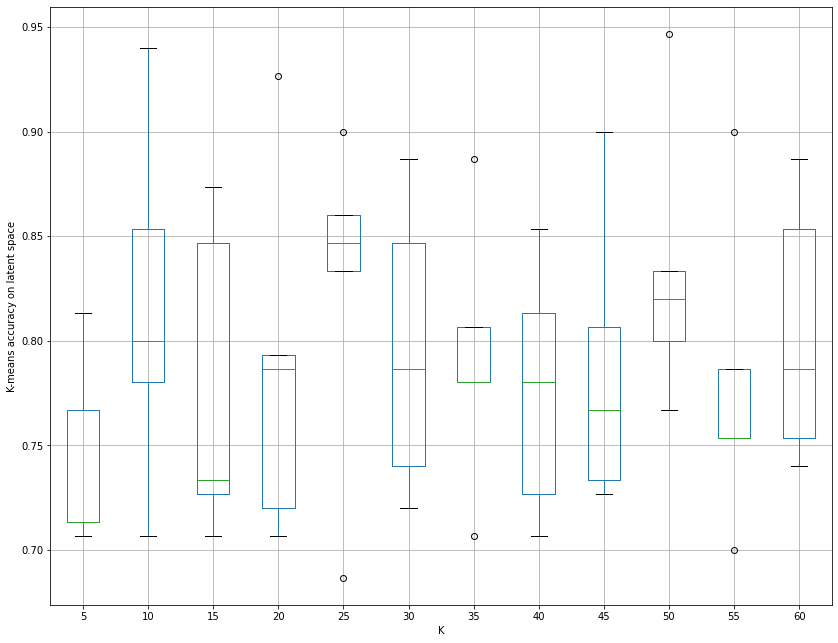

In [ ]:
columns = ['5', '10','15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

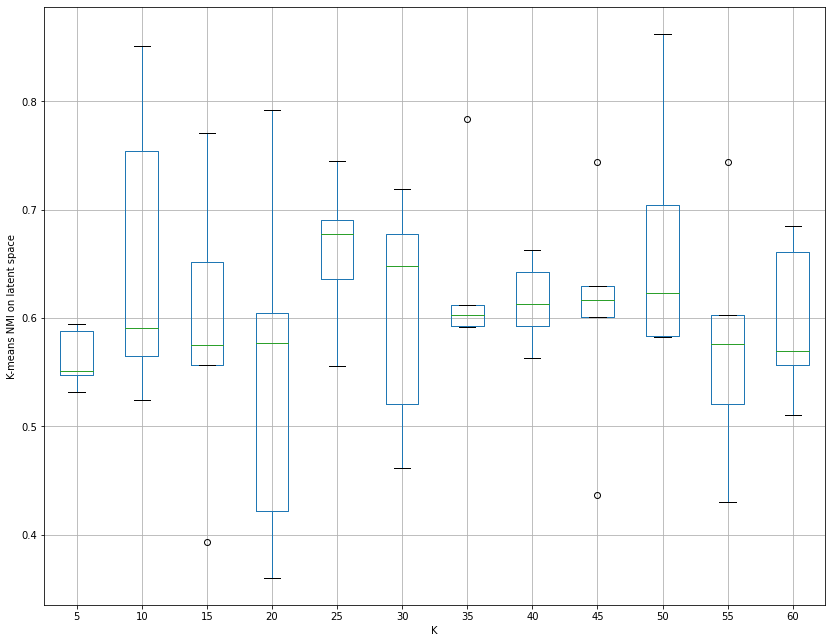

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

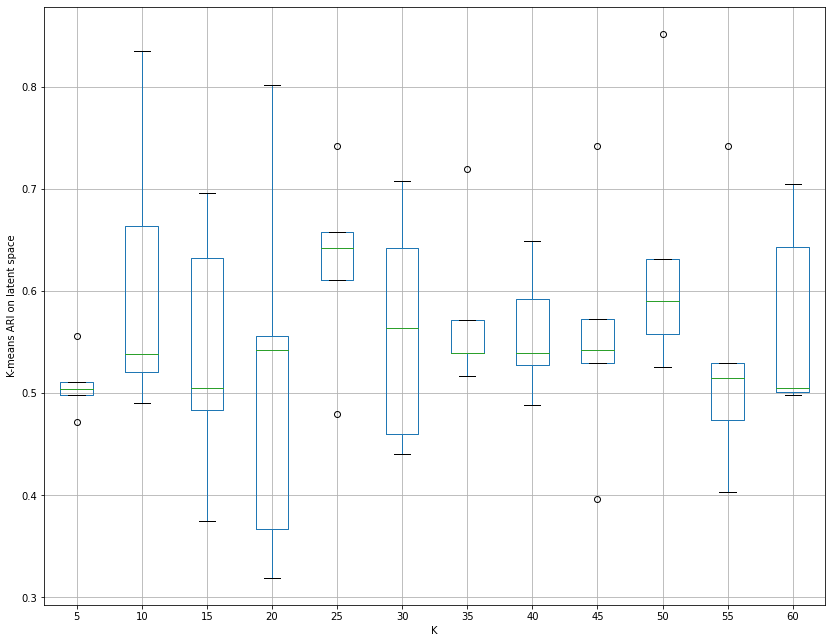

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

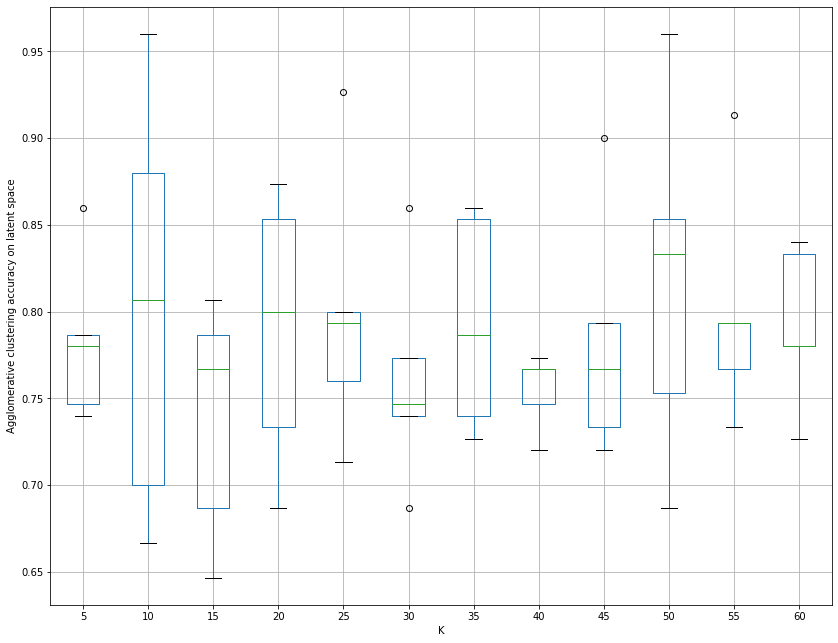

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

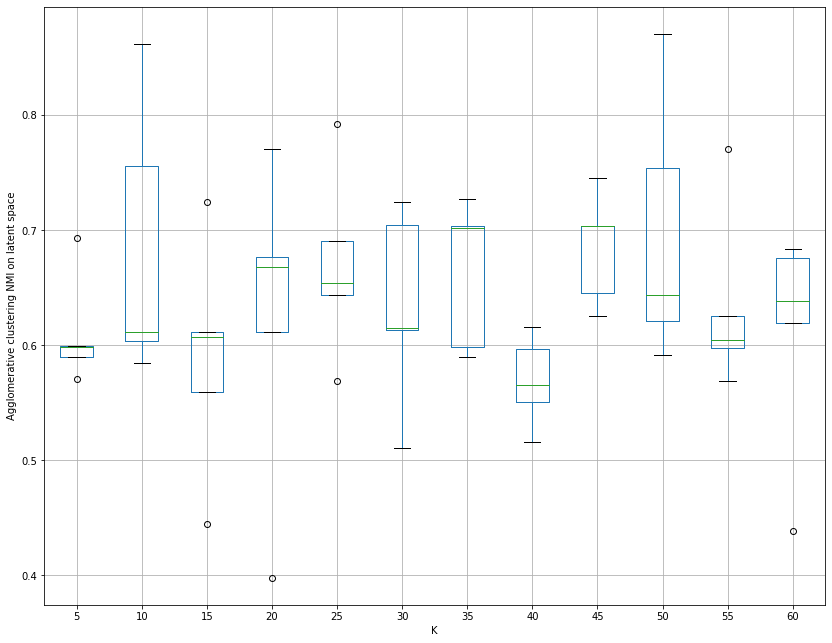

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

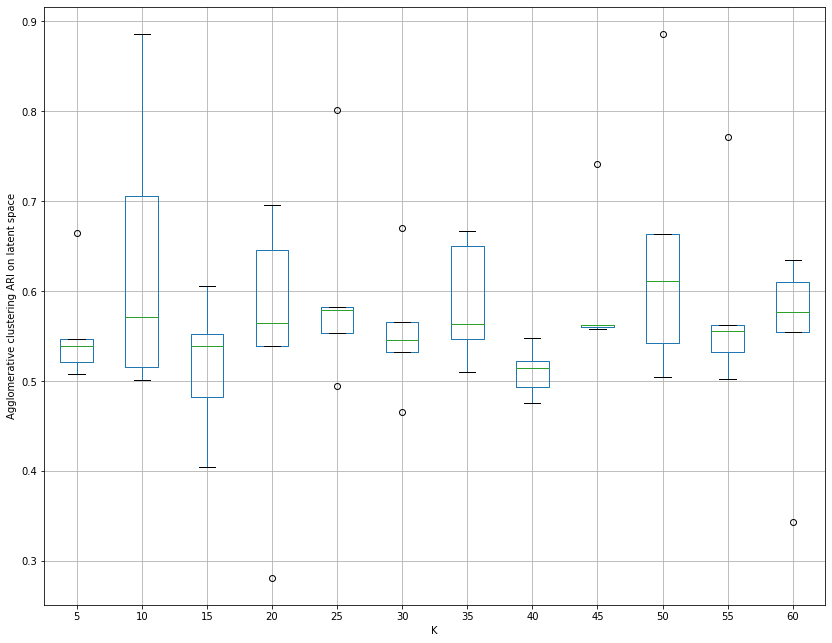

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

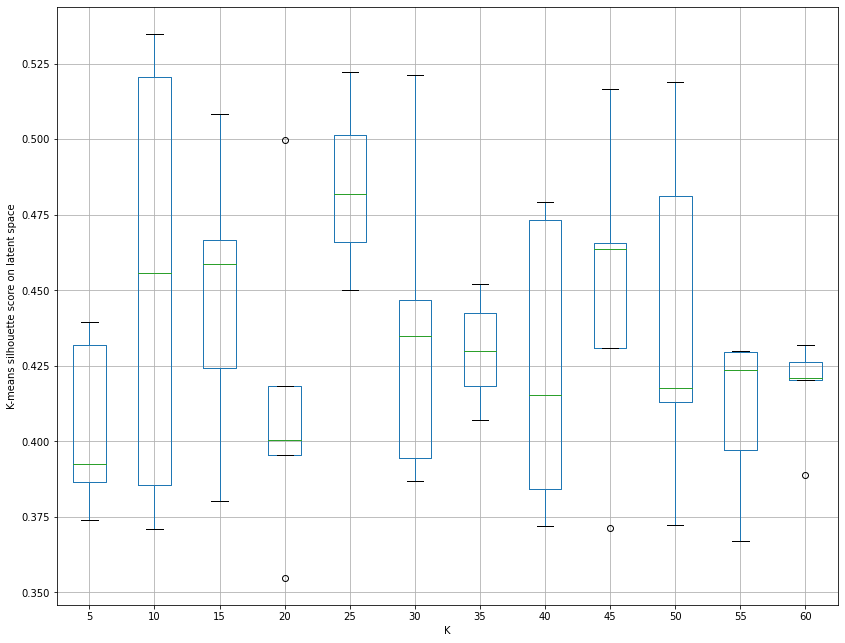

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')